# ST311 Homework 2 (Coding part)

Candidate number: 33349

# Week 5

## Q1 Class
1. Write a Python class named `Triangle` constructed by 3 numbers ( `x1`,`x2`,`x3`) and a method which will return `True` if the three numbers are the lengths of the three sides for an triangle, `False` otherwise.
(Hint: The necessary and sufficient condition for this to happen is that the sum of any two numbers must be great than the other. Also you may like to use the function `.sort()`) Below are several output examples.

In [13]:
class Triangle:
    def __init__(self, x1, x2, x3):
        self.x1 = x1
        self.x2 = x2
        self.x3 = x3
    
    def check(self):
        if (self.x1 + self.x2 < self.x3) or (self.x1 + self.x3 < self.x2) or (self.x2 + self.x3 < self.x1):
            return False
        else:
            return True

In [12]:
a = Triangle(1,2,1)
a.check()

True

In [14]:
a = Triangle(1,1.5,1)
a.check()

True

In [15]:
# additional check 

a = Triangle(1,2,4)
a.check()

False

## Q2 Dropout and Weight Decay 



1. We work with the Fashion-MNIST dataset introduced in Section 3.5. Run the following codes to import the data. 
1. Define an MLP with one hidden layers containing 256 units and  apply dropout to the output of the hidden layer (following the activation function). You could define this model by a new class called `Net` or using `nn.Sequential`.
1. Implement the SGD algorithm with `num_epochs, lr, batch_size = 20, 0.1, 100` to learn the model. You shall try a sequence of dropout probability and report the corresponding five-fold cross validation accucary rates.  Compare the results obtained when using dropout with those when not using it. Will dropout improve your model? Summarize your findings. (Please be careful that dropout operation shall only be activated during traning process. )

4.  We next implement the weight decay method. Please try a sequence of $\lambda$ value and  report the corresponding five-fold crossvalidation accuracy rates. Also,what happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? (This question is open-ended. For shallow network such as the network we are using in this question, it may be hard for you to observe a huge accuracy difference. However, combining weight decay and dropout usually works well in practice.)

In [16]:
# 1

%matplotlib inline
import torch
import torchvision
from torchvision import transforms
import numpy as np

trans = [transforms.ToTensor()]
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)

train_features = torch.tensor(np.array([mnist_train[i][0].numpy() for i in range(5000)]))
train_labels  = torch.tensor([mnist_train[i][1] for i in range(5000)])

In [17]:
# 2

import torch
from torch import nn
from d2l import torch as d2l

# defining an MLP with default dropout probability 0.5

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(256,10))


In [18]:
# 3

# defining the accuracy function

def accuracy(y_hat, y):  
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# defining the penalty
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# first define the training function that uses SGD

def sgd_train(net, X_train, y_train, num_epochs, lr, batch_size, lambd):
    
    w = net[1].weight
    
    metric = d2l.Accumulator(2)  # No. of correct predictions, no. of predictions
    
    train_iter = d2l.load_array((X_train, y_train), batch_size)
    
    # the SGD optimization algorithm is used here
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    # defining the Cross Entropy loss
    
    loss = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y) + lambd * l2_penalty(w) 
            l.backward()
            optimizer.step()
            metric.add(accuracy(y_hat, y), y.numel())
            
    return metric[0] / metric[1]

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_valid, y_valid


def k_fold_train(net, k, X_train, y_train, num_epochs, lr, batch_size, lambd):
    valid_acc_sum = 0
    
    for i in range(k):
        X_valid, y_valid = get_k_fold_data(k, i, X_train, y_train)
        valid_acc = sgd_train(net, X_valid, y_valid, num_epochs, lr, batch_size, lambd)
        valid_acc_sum += valid_acc
        
    return f'avg validation accuracy: {float(valid_acc_sum / k):f}'


In [19]:
dropouts = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
k, num_epochs, lr, batch_size = 5, 20, 0.1, 100

for dropout in dropouts:
    net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(256,10))
    print(net[3])
    print(k_fold_train(net, k, train_features, train_labels, num_epochs, lr, batch_size, 0))
    print("\n")
    

Dropout(p=0, inplace=False)
avg validation accuracy: 0.825380


Dropout(p=0.1, inplace=False)
avg validation accuracy: 0.820000


Dropout(p=0.3, inplace=False)
avg validation accuracy: 0.813120


Dropout(p=0.5, inplace=False)
avg validation accuracy: 0.800920


Dropout(p=0.7, inplace=False)
avg validation accuracy: 0.777260


Dropout(p=0.9, inplace=False)
avg validation accuracy: 0.652210




From the above results, we can see that increasing the dropout probability decreases the validation accuracy. From a dropout probability of 0 to a dropout probability of 0.9, we can see a validation accuracy decrease of about 20%.  Precisely, with a dropout probabiblity of 0 (ie. using all neurons in the hidden layer), the validation accuracy is very high: about 82% of the observations are correctly classified. On the other extreme, a dropout probability of 0.9 (the case where 90% of the neurons in the first hidden layer are turned off) yields a relatively low validation accuracy: only about 65% of observations are correctly classified. Consequently, we can conclude that the high accuracy we get from the naive model (using all neurons) is likely due to overfitting and the dropout method with sensible probabilities (0.1, 0.3 or even 0.5) yields more plausible and relatively stable validation accuracies (around 80%), hence reflecting the true predictive performance of our model. Indeed, using a very high dropout probability (such as 0.7 or 0.9) looses a considerable amout of information in our training and hence gives a poorer predictive performance. 

In [23]:
# 4

# training with weight decay and no dropout 

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(0),
                    nn.Linear(256,10))

k, num_epochs, lr, batch_size = 5, 20, 0.1, 100


lambds = [0, 0.1, 0.4, 1, 2, 5, 10]

for lambd in lambds:
    print("lambda: {}".format(lambd))
    print(k_fold_train(net, k, train_features, train_labels, num_epochs, lr, batch_size, lambd))
    print("\n")
    

lambda: 0
avg validation accuracy: 0.824120


lambda: 0.1
avg validation accuracy: 0.794860


lambda: 0.4
avg validation accuracy: 0.649080


lambda: 1
avg validation accuracy: 0.507010


lambda: 2
avg validation accuracy: 0.391870


lambda: 5
avg validation accuracy: 0.274370


lambda: 10
avg validation accuracy: 0.210040




In [24]:
# 4 cont'd

# training with weight decay and dropout (with a default dropout probability of 0.5)

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(256,10))

k, num_epochs, lr, batch_size = 5, 20, 0.1, 100

lambds = [0, 0.1, 0.4, 1, 2, 5, 10]



for lambd in lambds:
    print("lambda: {}".format(lambd))
    print(k_fold_train(net, k, train_features, train_labels, num_epochs, lr, batch_size, lambd))
    print("\n")


lambda: 0
avg validation accuracy: 0.802020


lambda: 0.1
avg validation accuracy: 0.776070


lambda: 0.4
avg validation accuracy: 0.626790


lambda: 1
avg validation accuracy: 0.476140


lambda: 2
avg validation accuracy: 0.357190


lambda: 5
avg validation accuracy: 0.221640


lambda: 10
avg validation accuracy: 0.152290




From the above results, we can observe that a weight decay regularisation decreases the validation accuracy rate, and that higher values of the penalty term lead to a further decrease in the accuracy. With no dropout, we can observe that setting a value of lambda beyond 1 leads to an accuracy below 50% which signals that our model is highly inefficient and performs very poorly. On the other hand, with a value of 0.1 for the reguliser term, we get a validation accuracy of about 77%. This is lower than the validation accuracy of 80% we get without the penalty, showing that the weight decay regularisation method is efficient in reducing the overfitting issue in our model which signals a spurious high accuracy rate in the first instance.

When weight decay is used with dropout (with a default probability of 0.5), we can see that the validation accuracy rates are lower than those without dropout for all values of lambda. This shows that the effects of weight decay and dropout regularisation methods are additive. At an optimal value of lambda (0.1 in our case), the accuracy rate is 2 percentage point lower with dropout than without. While this doesn't indicate a considerable change, we can already see that combining both regularisation methods leads to a more precise validation accuracy rate and hence a better measure of the true predictive performance of our model (that is, without the obscuring effect of overfitting the data). 

To conclude our analysis, both regularisation methods seem to perform efficiently, whether in combination or seperately, in reducing the variance of our neural network. However, to measure the true quality of the fit given by our model, one should also assess whether such regularisations are done at the cost of increasing bias, and how bias reacts to a decrease in variance (according to the bias-variance tradeoff).

# Week 6
## Q1 Blocks and Parameter Management
1. Use `MySequential()` in Section 5.1 Layers and Blocks to create an MLP with two hidden layers and a 2-dimensional output layer. The first hidden layer has 10 hidden units and the second hidden layer has 5 hidden units. The number of input features is 10.
2. Print the architecture of the above network and inspect the parameters of all the layers.
3. Change `MySequential()` to store blocks in a Python list, and redo question 2. What kinds of problems will occur?

In [25]:
# 1

class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `Module` subclass. We save it
            # in the member variable `_modules` of the `Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

# defining the MLP with MySequential()

net = MySequential(nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 5), nn.ReLU(), nn.Linear(5, 2))

In [26]:
# 2

# printing the architecture of the above MLP 

print("network architecture: \n {}".format(net))

print("\n")

# printing the parameters of all layers

print("parameters of the first hidden layer: \n {}".format(net._modules['0'].state_dict()))

print("\n")

print("parameters of the second hidden layer: \n {}".format(net._modules['2'].state_dict()))

print("\n")

print("parameters of the output layer: \n {}".format(net._modules['4'].state_dict()))



network architecture: 
 MySequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=2, bias=True)
)


parameters of the first hidden layer: 
 OrderedDict([('weight', tensor([[ 0.3109, -0.3096, -0.2706, -0.2570, -0.2523, -0.1427, -0.1660, -0.2144,
         -0.0553,  0.2135],
        [-0.1638,  0.2695,  0.0153,  0.0634,  0.1784, -0.0970, -0.2005, -0.1970,
          0.2269,  0.0497],
        [ 0.2615, -0.0670,  0.0602,  0.3136,  0.0526,  0.0358, -0.2250, -0.1314,
          0.1197, -0.2889],
        [-0.1353,  0.2780,  0.1829,  0.3026,  0.1696, -0.0919,  0.2753,  0.0416,
          0.0525, -0.1664],
        [ 0.1625,  0.2896,  0.0037, -0.2976, -0.1109, -0.0199, -0.2064, -0.2437,
          0.1803,  0.2244],
        [-0.2602,  0.2143,  0.2399,  0.1486, -0.1902, -0.2618,  0.0308, -0.0871,
         -0.1426, -0.1309],
        [ 0.2753, -0.1217, -0.1892,  0.25

In [27]:
# 3

# changing MySequential() to store blocks in a Python list

class MySequential(nn.Module):
    def __init__(self, *args):
        self.blocks = []
        super().__init__()
        for idx, module in enumerate(args):
            self.blocks.insert(idx, module)

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X
    
# redoing question 2

net = MySequential(nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 5), nn.ReLU(), nn.Linear(5, 2))

print(net)

print("\n")

print("network architecture: \n {}".format(net.blocks))

print("\n")

print("parameters of the first hidden layer: \n {}".format(net.blocks[0].state_dict()))

print("\n")

print("parameters of the second hidden layer: \n {}".format(net.blocks[2].state_dict()))

print("\n")

print("parameters of the output layer: \n {}".format(net.blocks[4].state_dict()))


MySequential()


network architecture: 
 [Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=5, bias=True), ReLU(), Linear(in_features=5, out_features=2, bias=True)]


parameters of the first hidden layer: 
 OrderedDict([('weight', tensor([[-0.1569,  0.1981,  0.0273,  0.2905,  0.2980,  0.3139,  0.0252,  0.2551,
          0.0279,  0.0897],
        [ 0.2073, -0.2958, -0.1904,  0.2731, -0.0185, -0.2983,  0.0551, -0.1932,
          0.1261, -0.0300],
        [-0.1924,  0.3033,  0.3141,  0.1948,  0.1716, -0.2351, -0.3012, -0.0119,
          0.0951, -0.3158],
        [-0.0979, -0.1561,  0.3044, -0.1357,  0.1454,  0.1670,  0.1493,  0.1477,
          0.0531,  0.1005],
        [ 0.1703,  0.2625, -0.1308,  0.1205, -0.2041,  0.0306,  0.0951,  0.2725,
          0.0187,  0.2709],
        [-0.1239, -0.0317,  0.1311, -0.3116,  0.3151, -0.2649,  0.1894, -0.2177,
         -0.0789,  0.1015],
        [ 0.0667, -0.0667, -0.0222, -0.1561, -0.0797,  0.0378, -0.173

From the above results, we can see that although the two ways of storing blocks are equivalent (in the sense that they give the same network structure), the access to a particular block is facilitated by the ```\_modules``` ordered dictionary. Indeed, storing the blocks in the the dictionary of the ```Module()``` class allows an indexed access to the information of every layer, the index of which is displayed in the network's architecture shown by ```print(net)```. Although storing the layers in a Python list shows the same hierarchy of layers, it does not display the index of each layer in the architecture, thus making the access to the information less straightforward than in the ordered dictionary. On a side note, as the Python list ```blocks``` is not an attribute of the ```Module()``` class, it does not form part of the network's definition directly, but is rather an attribute of ```MySequential()``` subclass of the ```Module()``` class. Hence to print the network's architecture, we need to invoke that attribute such as ```print(net.blocks)```. From an efficiency perspective, defining such an attribute results in an overhead as it useless and makes the accessing less straightfoward (we need to keep track of this variable every time we want to print the network's architecture).

## Q2 Blocks
1. Implement a block that takes two blocks as an argument, say `net1` and `net2` and returns the concatenated output of both networks in the forward propagation. This is also called a parallel block. Verify that your block works as intended by feeding your own `net1`, `net2` and some randomly simulated data through it.

In [28]:
class Concat(nn.Module):
    def __init__(self, net1, net2, *args):
        super().__init__()
        self.net1 = net1
        self.net2 = net2
    
    def forward(self, x):
        out1 = self.net1(x)
        out2 = self.net2(x)
        return torch.cat((out1, out2), 0)

x = torch.rand(2, 20)
net1 = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net2 = nn.Sequential(nn.Linear(20,256), nn.ReLU(), nn.Linear(256, 10))

print(net1(x))
print(net2(x))

print(Concat(net1, net2).forward(x))

tensor([[ 0.0495, -0.0116, -0.1537, -0.1172,  0.1459,  0.0607,  0.2128,  0.0321,
         -0.0712,  0.1774],
        [ 0.0350,  0.1994, -0.2156, -0.0776, -0.0968, -0.0198,  0.1041, -0.0420,
         -0.0523,  0.1888]], grad_fn=<AddmmBackward>)
tensor([[ 0.1872, -0.0524,  0.1178, -0.0522,  0.1765, -0.2887, -0.0231, -0.0935,
         -0.0718, -0.1616],
        [ 0.1551, -0.0710, -0.1384, -0.1605,  0.0658, -0.4181, -0.0910, -0.0548,
          0.1907, -0.1661]], grad_fn=<AddmmBackward>)
tensor([[ 0.0495, -0.0116, -0.1537, -0.1172,  0.1459,  0.0607,  0.2128,  0.0321,
         -0.0712,  0.1774],
        [ 0.0350,  0.1994, -0.2156, -0.0776, -0.0968, -0.0198,  0.1041, -0.0420,
         -0.0523,  0.1888],
        [ 0.1872, -0.0524,  0.1178, -0.0522,  0.1765, -0.2887, -0.0231, -0.0935,
         -0.0718, -0.1616],
        [ 0.1551, -0.0710, -0.1384, -0.1605,  0.0658, -0.4181, -0.0910, -0.0548,
          0.1907, -0.1661]], grad_fn=<CatBackward>)


## Week 7
## Q1.1 Momentum and Nestorov’s accelerated gradient
1. Assume the loss function (objective function) has the form of $f(x) = 0.1x_1^2+2 x_2^2$. Use the `d2l.show_trace_2d()`  function to plot the convergence trajectory of momentum algorithm with `eta, beta = 0.3, 0.5`, `lr = constant_lr` and `steps = 20`. (You could use the `f_2d(x1,x2)` and `momentum_2d(x1, x2, v1, v2)` functions from the workshop or write your own functions.)
1. Write your own `NAG_2d(x1, x2, v1, v2)` function to implement the Nesterov Accelerated Gradient (NAG) method. Plot its convergence trajectory  under the same setting (`eta, beta = 0.3, 0.5`, `lr = constant_lr` and `steps = 20`).
1. Compare the results between momentum and NAG methods and summarize what you have discovered.

epoch 20, x1: -0.289993, x2: 0.001723


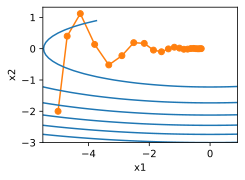

In [29]:
# 1

# defining the loss with f_2d(x1, x2) function

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

# defining the momentum algorithm

def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

# setting the parameters

eta, beta = 0.3, 0.5

# plotting the convergence trajectory

d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d, steps=20))

epoch 20, x1: -1.450531, x2: -0.000000


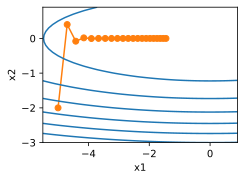

In [30]:
# 2

# defining the NAG algorithm

def NAG_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * (x1 + beta * v1)
    v2 = beta * v2 + 4 * (x2 + beta * v2)
    return x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, v1, v2

# setting the parameters

eta, beta = 0.3, 0.5

# plotting the convergence trajectory

d2l.show_trace_2d(f_2d, d2l.train_2d(NAG_2d, steps=20))


(3) From the above results, we can see that the momentum algorithm yields the following solution:  x1 = -0.289993 and x2 = 0.001723. On the other hand, the NAG method yields a solution for x1 = -1.450531 and x2 = -0.000000. Clearly, convergence in the x2 direction is much faster with NAG than it is with momentum as, for the same number of epochs, NAG has reached the optimum in the x2 component. As the plot suggests, this accelerated convergence is due to the fact that NAG benefits from a look-ahead in the the future parameter values, so it reaches the minimum much faster than momentum. For the x1 direction, NAG doesn't give a considerable improvement in convergence (in fact the NAG algorithm overshoots the minimum more than momentum does). Since NAG is not an adaptive approach, the convergence towards the optimum of x2 has led the algorithm to overshoot over the minimum in x1 (which is attained much faster, since the gradient in this direction is smaller). In this particular case, since NAG has reached the minimum in x2, it gives a better quality solution than momentum. 

## Q1.2 Decaying learning rates
1. Following Q1.1, we next change the setting to `eta, beta = 0.3, 0.9`, `lr = constant_lr` and `steps = 500`. Plot the trajectories of both momentum and NAG methods. What happens now when we use a larger value of $\beta$?
1. Try out the polynomial decay learning rate schedule $\eta(t) = \eta_0 (\alpha t+1)^{-0.5}$ with $\alpha = 3$. Plot the corresponding trajectories for both methods and summarize your findings.

In [31]:
# 1

# setting the new parameters

eta, beta = 0.3, 0.9


epoch 500, x1: 0.000000, x2: -0.000000


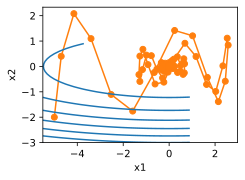

In [32]:
# plotting trajectory of momentum

d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d, steps=500))

epoch 500, x1: -0.000000, x2: 0.000000


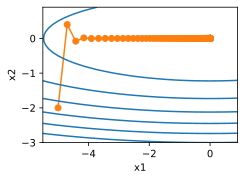

In [33]:
# plotting trajectory of NAG

d2l.show_trace_2d(f_2d, d2l.train_2d(NAG_2d, steps=500))

For the momentum approach, a larger value of beta amounts to a long-range average over past gradients. That is, a larger value of beta gives a more important weight to precedent gradient, hence a larger update step. Compared to the previous case, it has now made the oscillation worse in the x2 direction. Nonetheless, it appears to have reached the optimum in both directions (x1 , x2) = (0, 0). 

Since NAG computes the gradient at the extended step involving beta, a larger value of beta amounts to a longer extended step where the gradient is computed. From the above plots, we can see that the NAG algorithm seem to converge for both x1 and x2, and that the overshooting problem encoutered in the previous part has been resolved by taking a larger beta value. This may be due to the fact that, since the minimum in x1 is attained much faster, taking a larger extended step allowed the algorithm to detect a positive slope in the x1 direction and hence reduce the step size accordingly (thereby reaching the optimum in the x1 component).

epoch 500, x1: -0.000000, x2: -0.000000


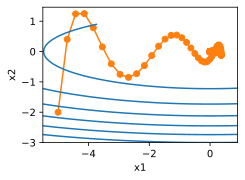

In [34]:
# 2 

# defining the polynomial decay learning rate schedule

class PolynomialScheduler:
    def __init__(self, lr):
        self.lr = lr
    
    def __call__(self, num_update):
        return self.lr * pow(3 * num_update + 1.0, -0.5)
    
# setting the parmeters

beta = 0.9

scheduler = PolynomialScheduler(lr=0.3)

# changing train_2d function from d2l

def train_2d(trainer, steps=20, f_grad=None):
    """Optimize a 2D objective function with a customized trainer.

    Defined in :numref:`subsec_gd-learningrate`"""
    # `s1` and `s2` are internal state variables that will be used later
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2, i)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

# changing the momentum trainer

def momentum_2d(x1, x2, v1, v2, i):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - scheduler(i) * v1, x2 - scheduler(i) * v2, v1, v2

# plotting the trajectory of momentum

d2l.show_trace_2d(f_2d, train_2d(momentum_2d, steps=500))


epoch 500, x1: -1.060650, x2: 0.000000


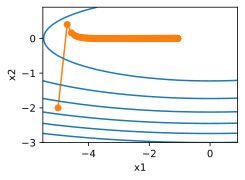

In [35]:
# changing the NAG trainer

def NAG_2d(x1, x2, v1, v2, i):
    v1 = beta * v1 + 0.2 * (x1 + beta * v1)
    v2 = beta * v2 + 4 * (x2 + beta * v2)
    return x1 - scheduler(i) * 0.2 * x1, x2 - scheduler(i) * 4 * x2, v1, v2,

# plotting the trajectory of NAG

d2l.show_trace_2d(f_2d, train_2d(NAG_2d, steps=500))


From the above plots, we can see that the learning rate decay for momentum has a notable effect in decreasing the oscillation along the x2 direction, giving us a smoother convergence to the optimum (x1, x2) = (0, 0) (in fact, the algorithm reaches that optimum). On the other hand, for NAG, it looks like decaying the learning rate has overshoot the minimum in the x1 direction. From the plot, it is evident that convergence in the x2 direction is faster with decaying learning rate. This may be due, for example, to the fact that the previously large learning rate created a bouncing effect: the algorithm kept bouncing around the minimum wihout reaching optimality. On the other hand, the minimum in the x1 direction has been skipped through: the decaying step sizes were not enough for reaching optimality within 500 epochs. (See below a supporting plot where the algorithm using decayed learning rates converges closely to the optimum within 80000 epochs)

epoch 8000, x1: -0.010147, x2: 0.000000


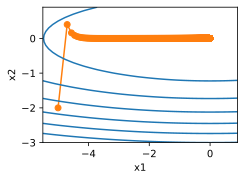

In [36]:
d2l.show_trace_2d(f_2d, train_2d(NAG_2d, steps=8000))

## Q2 Momentum, RMSProp and ADAM
In this question, we will explore some effective optimazation algorithms: momentum, RMSProp and Adam. 

1. Familiarise yourself with the `train_2d(trainer, steps=20, f_grad=None)`, `sgd_momentum(params, states, hyperparams)`, `rmsprop(params, states, hyperparams)` and `adam(params, states, hyperparams)` functions we introduced in class. 

1. In practice, your loss function usually will not have a 'beautiful' form. Please write your own `train_2d()` function aiming to find the minimum of any 2D objective functions. You could use the `train_2d(trainer, params, init_states, hyperparams, steps=20)` structure provided below. Also, please provide the trainer functions for the momentum, RMSProp and Adam methods respectively.

1. We next consider $f(x) = sin(x_1+x_2)+(x_1-x_2)^2-1.5x_1+2.5x_2+1$ as our objective function. Please try all of these three algorithms: momentum, RMSProp and Adam, to find the minimum of this function. During learning process, we set the related hyperparams `momentum, gamma = 0.9, 0.99`, which are common choices for the adam algorithms in practice, and `steps = 500`. The initial ($x_1,x_2$) is set to be $(-2,2).$ Try out the learning rate of `lr = 0.05`, `lr = 0.2` and `lr = 0.5`. Under each learning rate, you are supposed to (1) run your `train_2d()` to print out the final result of $(x_1, x_2)$ and (2) show the convergence trajectory if the algorithm works fine (does not explode). 
(You are welcomed to use the codes presented below.)

1. Compare the performance of these three algorithms in terms of the estimation accuracy and convergence trajectory. Given that the minimum of $f(x)$ if $x_1 \in [-1.5, 4], x_2 \in [-3, 4]$ is at $x_1 = -0.54719$ and $x_2=-1.54719,$  which method tends to give you the best performance in terms of finding this local minimum?


In [1]:
import torch
import numpy as np
from d2l import torch as d2l

# initialising the states

def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    return [v_w]

def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    return [s_w]

def init_adam_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    s_w= torch.zeros((feature_dim, 1))
    return [[v_w, s_w]]

# plot function

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x_max = list(map(max, zip(*results)))
    x_min  = list(map(min, zip(*results)))
    x1, x2 = torch.meshgrid(torch.arange(min(-2.0,x_min[0]-0.1), max(2.0,x_max[0]+0.1), 0.1),
                          torch.arange(min(-2.0,x_min[1]-0.1), max(2.0,x_max[1]+0.1), 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

#init_x = torch.tensor([[-2.0],[2.0]], requires_grad=True)

In [2]:
# 1

def train_2d(f, x, y, trainer, init_states, hyperparams, steps):
    
    """Optimize a 2D objective function with a customized trainer.
    trainer: can be momentum, RMSProp or Adam
    params: parameters that need to be estimated. weights and bias in practice, x_1 and x_2 in this example
    init_states: different for different trainer
    hyperparams: hyperparameters (dictionary)
    steps: steps"""
        
    results = []
    
    for i in range(steps):  
        z = f(x,y)
        z.backward()
        params = trainer([x,y], init_states, hyperparams)
        results.append(params.clone().reshape(2).detach().numpy())
        
    print(f'epoch {i + 1}, x: {(params)}')
    return results

# optimisation algorithms modified to return params

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states[0]):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()
    return torch.tensor(params)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states[0]):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()
    return torch.tensor(params)

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states[0]):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
        hyperparams['t'] += 1
    return torch.tensor(params)

# defining our function

f = lambda x1, x2: torch.sin(x1 + x2) + (x1 - x2) ** 2 - 1.5 * x1 + 2.5 * x2 + 1

x = torch.tensor([-2.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)

epoch 500, x: tensor([-0.5472, -1.5472])


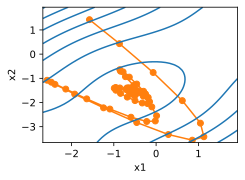

In [39]:
# 2

#training with Momentum algorithm
    
# 0.05 learning rate

show_trace_2d(f, train_2d(f, x, y, sgd_momentum, init_momentum_states(2), {'lr': 0.05, 'momentum': 0.9}, steps=500))


epoch 500, x: tensor([-488.8528, -489.8528])


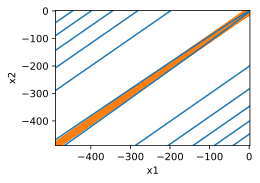

In [4]:
# 0.2 learning rate

show_trace_2d(f, train_2d(f, x, y, sgd_momentum, init_momentum_states(2), {'lr': 0.2, 'momentum': 0.9}, steps=500))

epoch 500, x: tensor([-1523.8936, -1524.8933])


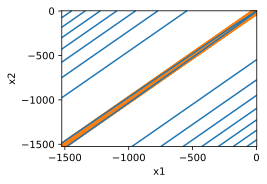

In [4]:
# 0.5 learning rate

show_trace_2d(f, train_2d(f, x, y, sgd_momentum, init_momentum_states(2), {'lr': 0.5, 'momentum': 0.9}, steps=500))

epoch 500, x: tensor([-0.5472, -1.5472])


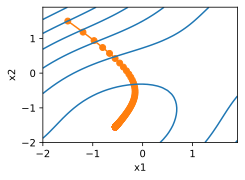

In [3]:
# training with RMSProp algorithm

# 0.05 learning rate

show_trace_2d(f, train_2d(f, x, y, rmsprop, init_rmsprop_states(2), {'lr': 0.05, 'gamma': 0.99}, steps=500))


epoch 500, x: tensor([-0.4721, -1.6221])


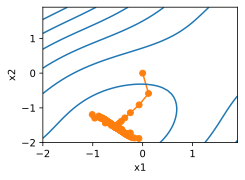

In [3]:
# 0.2 learning rate

show_trace_2d(f, train_2d(f, x, y, rmsprop, init_rmsprop_states(2), {'lr': 0.2, 'gamma': 0.99}, steps=500))

epoch 500, x: tensor([-0.6518, -1.4426])


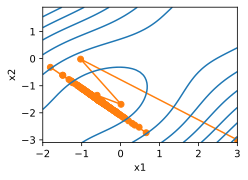

In [3]:
# 0.5 learning rate

show_trace_2d(f, train_2d(f, x, y, rmsprop, init_rmsprop_states(2), {'lr': 0.5, 'gamma': 0.99}, steps=500))


epoch 500, x: tensor([-0.5472, -1.5472])


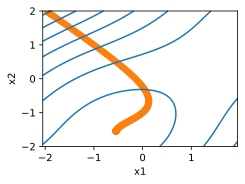

In [3]:
# training with ADAM algorithm

# 0.05 learning rate

show_trace_2d(f, train_2d(f, x, y, adam, init_adam_states(2), {'lr': 0.05, 't': 1}, steps=500))


epoch 500, x: tensor([-0.5472, -1.5472])


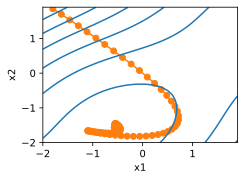

In [3]:
# 0.2 learning rate

show_trace_2d(f, train_2d(f, x, y, adam, init_adam_states(2), {'lr': 0.2, 't': 1}, steps=500))


epoch 500, x: tensor([-0.5472, -1.5472])


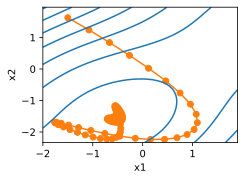

In [3]:
# 0.5 learning rate

show_trace_2d(f, train_2d(f, x, y, adam, init_adam_states(2), {'lr': 0.5, 't': 1}, steps=500))


From the above results, we can see that the ADAM algorithm yields the smoothest and most precise convergence to the optimum, contrary to RMSProp and SGD Momentum which suffer from oscillations as well as imprecision. Indeed, the SGD momentum doesn't attain the optimum in either case and has an oscillating trajectory even for a small learning rate of 0.05. Moreover, it appears to diverge quickly for small increases in the learning rate (0.2 or higher). While RMSProp seems to converge to the optimum for a learning rate of 0.05, it becomes imprecise and fails to attain the optimum when the learning rate is 0.2 or larger. On the same occasion, RMSProp shows more oscillations for larger step sizes. On the otherhand, while increasing the learning rate has made the ADAM approach less efficient (from the plots, we can see that it took more steps to find the optimum), it appears to have no effect on the accuracy as the algorithm attains the optimum in the three tested cases. Assuming we know that the optimum is at x1 = −0.54719 and x2 = −1.54719, we can see that ADAM gives the best quality solution as it converges most closely to that optimum (and provides a convergence guarantee regardless of the step size) among the three tested algorithms.